In [1]:
pip install import_ipynb     

Note: you may need to restart the kernel to use updated packages.


In [2]:
import import_ipynb

In [3]:
#Import functions
import numpy as np
import math
import matplotlib.pylab as plt
from queue import PriorityQueue
from scipy import stats as s
import timeit

#Import Supporting files
import display
import find_new_dim


importing Jupyter notebook from display.ipynb
importing Jupyter notebook from find_new_dim.ipynb


In [4]:
class OriginalMaze(object):            

    def __init__(self, x = None, y = None, open = None):
        self.closed_set = set()         
        self.fringe = PriorityQueue()   # Use a priority queue for the fringe
        self.relax_fringe = PriorityQueue()   # Use a priority queue for the fringe
        self.max_fringe_size = 0   
        self.max_relax_fringe_size = 0   
        self.nodes = []                 # List to store all the maze nodes
        self.relax_nodes =[]            #relaxed maze
        self.dim = 0                    # Dimension of the maze
        self.x = x                      # x co-ordinate of node
        self.y = y                      # y co-ordinate of node
        self.parent = None
        self.h = 0                      # Heuristic value
        self.f = 0                      # F-value
        self.cost = {}                  # Dict to store path costs
        self.shortest_path_length = 0
        self.shortest_relax_path_length = 0
        self.nodes_expanded = 0
        self.relax_nodes_expanded = 0
        self.open = open                # Bool: True if node is open, False if node is blocked
        self.finish = False             # Bool: True when goal is found
        
        
    def create_maze(self, dim, p):
        """
        Create the maze: 
        Blocked nodes are represented by 0 (with probability 'p'), 
        Open nodes by 1 (with probability '1-p'), and
        Traversed nodes by 2
        :param dim: dimension of the maze to be created
        :param p: probability of obstacles/obstacle density
        """
        self.new_dim =find_new_dim.divide_dim(dim)     #getting new dimension of a Superblock
        if self.new_dim:
            self.dim = dim
            maze = np.random.choice([0, 1], (dim,dim), p=[p, 1-p]) # [Blocked/0, Open/1]
            maze[0][0] = 2          # Denote start by 2
            maze[dim-1][dim-1] = 2  # Denote goal by 2
            return maze
      
    #Create a symbolic version of the relaxed sized maze
    def create_relax_maze(self,dim,p):
        self.dim = dim
        maze = np.random.choice([1], (dim,dim))
        maze[0][0] = 2          # Denote start by 2
        maze[dim-1][dim-1] = 2  # Denote goal by 2
        return maze
    
    #Calculating new dimension of the superblocks
    def get_newdim (self,dim,p):
        self.new_dim =find_new_dim.divide_dim(dim)
        new_dim = self.new_dim
        return new_dim
        
    def get_node(self, x, y):
        #self.dim = dim
        return self.nodes[x * self.dim + y]

    # Find immediate neighbors of any given node
    def find_neighbors(self, node):
        nodes = []
        # Right
        self.dim =dim
        if node.x < self.dim-1:
            nodes.append(self.get_node(node.x + 1, node.y))
        # Left
        if node.x > 0:
            nodes.append(self.get_node(node.x - 1, node.y))
        # Up
        if node.y < self.dim-1:
            nodes.append(self.get_node(node.x, node.y + 1))
        # Down
        if node.y > 0:
            nodes.append(self.get_node(node.x, node.y - 1))
        return nodes 
    
    #Function to create relaxed version of the original maze 
    """
    The Relaxation technique name : "Cubes inside a Cube :)"
    Shortest Path finding Algorithm : Astar Technique
    
    Note: Two methods for calculating relaxation cost are used
          1)Blocked Neighbor Weight
          2)Blockage Probability as a weight
          
    Result: The method 2 works efficiently than method 1 in higher dimensions
            The savings of the node surfing in higher dimnsions is huge
            for dim = 1000, p=0.3 ,No of saved nodes=143600 (Good Savings!!)
            The highest dim value = 2000 can be solved in considerable time :)
    """
    def init_maze(self, dim, p):        
        """
        Initialize the maze with given dim and p
        :param dim: dimension of the maze to be created
        :param p: probability of obstacles/obstacle density
        """
        self.original_maze = self.create_maze(dim, p)     #Creating of new maze
        #self.initial_maze = self.original_maze
        self.relaxed_maze =self.relax_maze(dim,p) 
        self.dim = dim                                    #original dim
        self.new_p =[]                                    #new probability of superblocks
        self.sum =[]                                      #Array for neighbor weight assignment                           
        self.total_sum = []                               # Array for sorting neighbor weights
        self.block_mode_val = []                          # calculating mode
        self.block_mode_max = []                          # Calculating max value of the sorted neighbor weights
        self.saved_nodes = 0                              # No of total saved nodes    
        self.i = []                                       #Array to store probability values for method-2
        self.t =[]                                        # Array to store blocked neighbor nodes for method-1 
       
        block_count = 0                                  #No of blocked cells inside the superblock
        open_count = 0                                   #No of open cells inside the superblock
        
        self.new_dim =self.get_newdim(dim,p)             #Get New Dimension of a relaxed maze
        new_dim = int(self.new_dim)                      #new_dim
        print('new dim',new_dim)
        
        ptr = int(self.dim/new_dim)                      #size of one superblock
        print('Size of one Superblock :',ptr)

        #Calculating weightage of the new superblocks open/blocked
        for row in range (new_dim):
            for column in range (new_dim):
                print('superblock dimension :',row,column)
                new_x = int(ptr*(row+1))
                new_y = int(ptr *(column+1))
                print(new_x,new_y)
                for x in range (new_x-ptr,new_x,1):
                    for y in range(new_y-ptr,new_y,1):
                        #Condition: node is blocked 
                        if self.original_maze[x][y] == 0:
                            open = False
                            block_count += 1
                            
                            """"
                            Method 1: Calculate weighatge of the blocked node according to its immediate blocked neighbors
                            Aim : Try to assign the blockage cost to new superblocks
                            To Do: 
                                1)Calculate number of immediate blocked nodes of the particular blocked cell 
                                2)Calculate its mode value and maximum value
                                3)Set a "Dynamic Threshold value" using mode value
                                4)Assign weightage cost to all superblocks
                                5)Display Newly weightaged relaxed version of the original maze!
                                6) Calculate number of "saved nodes" in the relaxed version of the maze
                            Result: Better results for high values of dim
                                    
                            """
                            self.t = 0
                            if x != dim - 1:
                                if self.original_maze[x+1][y] == 0:    #checking whether right neighbor cell is blocked
                                    self.t += 1
                            if self.original_maze[x-1][y] == 0:        #checking whether left neighbor cell is blocked
                                self.t += 1
                            
                            if y!= dim-1 :
                                if self.original_maze[x][y+1] == 0:    #checking whether bottom neighbor cell is blocked
                                    self.t += 1
                            if self.original_maze[x][y-1] == 0:        #checking whether up neighbor cell is blocked
                                self.t += 1
                            #if self.t>= 2:
                            self.sum.append(self.t)                    # append the no of neighbors of a blocked cell
                
                        # Condition: node is open
                        else:
                            open = True
                            open_count +=1
                        
                        self.nodes.append(OriginalMaze(x, y, open)) # Append all nodes to 'nodes' list
                        self.relax_nodes.append(OriginalMaze(row, column, open)) # 

                self.total_sum = self.sum
                print('The total weightage of a blocked cell:',self.total_sum)
                
                #Mode calculation 
                self.total_sum = np.sort(self.sum)[::-1]        # array sorting in descending order
                self.block_mode_val = s.mode(self.total_sum)[0]
                print('The mode of neighboring block nodes are:',self.block_mode_val)
                self.sum = []
                self.block_node_max= max(self.total_sum)
                
                #Dynamic Threshold value
                if self.block_node_max >= 3:           #Dense maze
                    new_threshold = 2
                elif self.block_node_max < 3:     #less dense maze
                    new_threshold = 1
                    
                #Assign new costs to cells of superblock
                if self.block_mode_val >= new_threshold:
                    self.saved_nodes+= 1
                    if row ==0 and column ==0:   #Exclude start node
                        self.relaxed_maze[row][column] = 2 
                    elif row ==new_dim-1 and column ==new_dim-1:   #Exclude end node
                        self.relaxed_maze[row][column] = 2
                    else:
                        self.relaxed_maze[row][column] = 0     #Relaxed maze block nodes
                        for x in range (new_x-ptr,new_x,1):
                            for y in range(new_y-ptr,new_y,1):
                                if self.original_maze[x][y]== 1: 
                                    self.original_maze[x][y]= 0     # block node
                                    open = False
                                    self.nodes.append(OriginalMaze(x, y, open)) # Append all nodes to 'nodes' list
                                            #node = self.nodes
                                    #print(self.nodes)
                            #return self.nodes     
                    
                            """"
                            Method 2: Calculate weighatge of the blocked node according to its blockage probability
                            Aim : Try to assign the blockage cost to new superblocks
                            To Do: 
                                1)Calculate number blocked and open nodes inside a superblock  
                                2)Calculate its blocked probability "p_superblock = (block cells/Total cells)"
                                3)Set a "Fixed Threshold value" using p_superblocks
                                4)Assign weightage cost to all superblocks
                                5)Display Newly weightaged relaxed version of the original maze!
                                6) Calculate number of "saved nodes" in the relaxed version of the maze
                            Result: Poor results as dim increases p_superblocks "converges" to original p 
                                    and fails to assign proper costs to new superblocks due to small variance
                                    
                            Note: The fixed threshold value is set to 3*original p value to check method 1 efficiency as of now
                                    
                            """
                # Probability Calculation            
                blockage_probability =block_count/(block_count+ open_count)
                self.i.append(blockage_probability) 
                self.new_p.append(OriginalMaze(row,column,blockage_probability))    #Append all probabilities to nodes
                print('The new probability of new cells are(x,y,p) :',row,column,blockage_probability)
                                       
                #Fixed Threshold
                threshold = p*3            
                if blockage_probability >= threshold:
                    self.saved_nodes+= 1
                    for x in range (new_x-ptr,new_x,1):
                        for y in range(new_y-ptr,new_y,1):
                            if row !=0 and column !=0:   #Exclude start node
                                if row !=new_dim-1 and column !=new_dim-1:   #Exclude end node
                                    if self.original_maze[x][y]== 1: 
                                        self.original_maze[x][y]= 0     # block node
                                        open = False
                                        self.nodes.append(OriginalMaze(x, y, open)) # Append all nodes to 'nodes' list
                                        self.relax_nodes.append(OriginalMaze(row, column, open)) # Append all nodes to 'nodes' list
        #Display probabilities of all superblocks
        print('The probabilities of relaxed maze are:')
        print(self.i)
        
        print('The relaxed maze is Ready!! ')
        display.print_maze(self.relaxed_maze)                     
        
        print('The combined version of original and relaxed maze is Ready!! ')
        display.print_maze(self.original_maze)
        
        #self.start = self.get_node(0,0)
        #self.ori_goal = [self.dim - 1, self.dim - 1]
        #self.relax_goal = self.get_node(self.new_dim-1,self.new_dim - 1)

        #Calculation of saved nodes
        print('The total number of nodes search saved is:',self.saved_nodes*ptr*ptr)
        
        return self.original_maze, self.relaxed_maze 
    
    def get_euclidean_dist(self, node):
        return np.sqrt((node.x - self.goal.x)**2 + (node.y - self.goal.y)**2)

    def get_manhattan_dist(self, node):
        return np.abs(node.x - self.goal.x) + np.abs(node.y - self.goal.y)

    def calc_heuristic(self, node, heuristic):
        if heuristic == "m":
            return self.get_manhattan_dist(node)
        return self.get_euclidean_dist(node)
          
      
    #Create original version of maze   
    def ori_maze(self, dim, p):
        self.maze = self.create_maze(dim, p)
        display.print_maze(self.maze)
        print('Original Maze is created!!')
        #maze =self.maze
        #print(maze)
        return self.maze
        
    #Creating relaxed version of maze
    def relax_maze(self,dim,p):
        self.dim = dim
        dim = self.get_newdim(dim,p)
        self.maze1 = self.create_relax_maze(dim,p)
        #display.print_maze(self.maze)
        print('Relaxed Maze is created!!')
        return self.maze1
    
    #Selecting relax maze for Astar
    def select_relax_maze (self,dim,p):
        original_maze, relaxed_maze= self.init_maze(dim,p)
        self.maze = relaxed_maze
        maze = self.relaxed_maze
        return maze
    
    #Selecting original maze for Astar
    def select_original_maze (self,dim,p):
        #original_maze, relaxed_maze= self.init_maze(dim,p)
        self.maze = self.original_maze
        maze = self.original_maze
        return maze
        
    # Relaxation Technique    
    def final_relaxed_maze (self,dim,p,heuristic):
        #original_maze, relaxed_maze= self.init_maze(dim,p)
        #self.ori_maze(dim,p)
        self.select_relax_maze(dim,p)
        #self.astar_in_relax_maze(dim,p,heuristic)
           
        print('done with relaxed maze')


    

In [5]:
class RelaxedMaze(object):

    def __init__(self, x = None, y = None, open = None):
        self.closed_set = set()         
        self.fringe = PriorityQueue()   # Use a priority queue for the fringe
        self.max_fringe_size = 0            
        self.nodes = []                 # List to store all the maze nodes
        self.dim = 0                    # Dimension of the maze
        self.x = x                      # x co-ordinate of node
        self.y = y                      # y co-ordinate of node
        self.parent = None
        self.h = 0                      # Heuristic value
        self.f = 0                      # F-value
        self.cost = {}                  # Dict to store path costs
        self.shortest_path_length = 0
        self.nodes_expanded = 0
        self.open = open                # Bool: True if node is open, False if node is blocked
        self.finish = False             # Bool: True when goal is found

   # def get_maze(self,dim,p):
        
    
    def get_node(self, x, y):
        return self.nodes[x * self.dim + y]

    # Find immediate neighbors of any given node
    def find_neighbors(self, node):
        nodes = []
        # Right
        if node.x < self.dim-1:
            nodes.append(self.get_node(node.x + 1, node.y))
        # Left
        if node.x > 0:
            nodes.append(self.get_node(node.x - 1, node.y))
        # Up
        if node.y < self.dim-1:
            nodes.append(self.get_node(node.x, node.y + 1))
        # Down
        if node.y > 0:
            nodes.append(self.get_node(node.x, node.y - 1))
        return nodes

    def init_maze(self, dim, p,maze,change):        
        """
        Initialize the maze with given dim and p
        :param dim: dimension of the maze to be created
        :param p: probability of obstacles/obstacle density
        """
        #self.maze = self.create_maze(dim, p)
        self.maze = maze
        if change ==1:
            self.dim = OriginalMaze.get_newdim (self,dim,p)
        elif change ==0:
            self.dim = dim
        for x in range(self.dim):
            for y in range(self.dim):
                # node is blocked
                if self.maze[x][y] == 0:
                    open = False
              # node is open
                else:
                    open = True
                self.nodes.append(RelaxedMaze(x, y, open)) # Append all nodes to 'nodes' list
        self.start = self.get_node(0, 0)
        self.goal = self.get_node(self.dim - 1, self.dim - 1)
        #print('self.start',  self.start)
        #print('self.goal', self.goal)
        print('length of self nodes',len(self.nodes))
        
    def get_euclidean_dist(self, node):
        return np.sqrt((node.x - self.goal.x)**2 + (node.y - self.goal.y)**2)

    def get_manhattan_dist(self, node):
        return np.abs(node.x - self.goal.x) + np.abs(node.y - self.goal.y)

    def calc_heuristic(self, node, heuristic):
        if heuristic == "m":
            return self.get_manhattan_dist(node)
        return self.get_euclidean_dist(node)
          
    # Function to display the shortest traversed path by agent from start to goal
    def display_path(self):
        node = self.goal # Set goal node
        self.shortest_path_length = 0
        print('\nPath traversed:\n')
        print('=== GOAL ===')
        
        # Find length of shortest path
        # Keep on expanding nodes until shortest path to goal is found 
        while node.parent is not self.start:
            #print('node.parent', node.parent)
            node = node.parent 
           
            self.shortest_path_length += 1
            self.maze[node.x][node.y] = 2
            print('(', node.x, ',', node.y, ')')            
            
        # Display the maze with highlighted path
        display.print_maze(self.maze)
        self.shortest_path_length += 2
        print('=== START ===\n')
        print('\nShortest path length: ',self.shortest_path_length)
        print('Nodes expanded: ',self.nodes_expanded)
        print('Maximum fringe size: ',self.max_fringe_size)
        
        return self.maze
    
    # Astar algorithm 
    def run_astar(self, dim, p, heuristic,maze,change):  
        self.init_maze(dim, p,maze,change)
        self.fringe.put((self.start.f, 0, self.start)) # Initiate fringe with f-val, nodes expanded, start node
        #print(self.fringe)
        #print('self.start.f',self.start.f)
        #print(self.maze)
        self.cost[self.start] = 0
        #print('self.start',self.start)
        # While fringe is not empty, add visited nodes to closed set
        while not self.fringe.empty():
            f_val, x, node = self.fringe.get()
            self.closed_set.add(node)       
            # Goal found
            if node is self.goal:         
                self.finish = True
                self.nodes_expanded += 1
                return self.display_path()
        
            neighbors = self.find_neighbors(node)
            for neighbor in neighbors:
                # Neighbor is open and unvisited
                if neighbor.open and neighbor not in self.closed_set:
                    new_cost = self.cost[node]   
                   
                    # Update cost if new cost is lower
                    if neighbor not in self.cost or self.cost[neighbor] > new_cost:
                        self.cost[neighbor] = new_cost        
                        neighbor.parent = node         
                        f_val = new_cost + self.calc_heuristic(neighbor, heuristic) 
                        self.fringe.put((f_val, self.nodes_expanded, neighbor)) 
                        self.max_fringe_size = len(self.fringe.queue)
                        self.nodes_expanded += 1
             
        # If there's no path from start to goal
        if(self.finish == False):
            display.print_maze(self.maze)
            print('This maze is unsolvable!')

        

        



Enter dimension of the maze (dim): 100
Enter obstacle probability (p): 0.2
Enter heuristic (Manhattan (m) / Euclidean (e)): m
The Dimensions of Original maze : 100
Lets check the relaxation heuristic with new dimension : 10


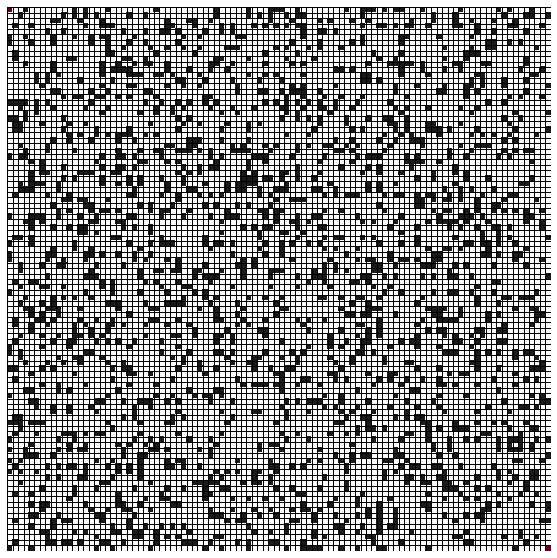

Original Maze is created!!
Hurray!!  The Original maze is created.. 


In [11]:
dim = int(input('Enter dimension of the maze (dim): '))
p = float(input('Enter obstacle probability (p): '))
heuristic = input('Enter heuristic (Manhattan (m) / Euclidean (e)): ')
obj1 = OriginalMaze()
Original_maze_form = obj1.ori_maze(dim,p)
print('Hurray!!  The Original maze is created.. ')





length of self nodes 10000

Path traversed:

=== GOAL ===
( 99 , 98 )
( 99 , 97 )
( 99 , 96 )
( 99 , 95 )
( 99 , 94 )
( 98 , 94 )
( 98 , 93 )
( 98 , 92 )
( 99 , 92 )
( 99 , 91 )
( 99 , 90 )
( 99 , 89 )
( 99 , 88 )
( 99 , 87 )
( 99 , 86 )
( 99 , 85 )
( 99 , 84 )
( 99 , 83 )
( 99 , 82 )
( 99 , 81 )
( 99 , 80 )
( 99 , 79 )
( 99 , 78 )
( 98 , 78 )
( 98 , 77 )
( 98 , 76 )
( 99 , 76 )
( 99 , 75 )
( 99 , 74 )
( 99 , 73 )
( 99 , 72 )
( 99 , 71 )
( 99 , 70 )
( 98 , 70 )
( 98 , 69 )
( 97 , 69 )
( 96 , 69 )
( 95 , 69 )
( 94 , 69 )
( 93 , 69 )
( 92 , 69 )
( 91 , 69 )
( 90 , 69 )
( 90 , 68 )
( 90 , 67 )
( 91 , 67 )
( 92 , 67 )
( 93 , 67 )
( 94 , 67 )
( 95 , 67 )
( 96 , 67 )
( 96 , 66 )
( 96 , 65 )
( 97 , 65 )
( 98 , 65 )
( 98 , 64 )
( 98 , 63 )
( 98 , 62 )
( 98 , 61 )
( 98 , 60 )
( 99 , 60 )
( 99 , 59 )
( 99 , 58 )
( 98 , 58 )
( 98 , 57 )
( 98 , 56 )
( 98 , 55 )
( 97 , 55 )
( 97 , 54 )
( 97 , 53 )
( 98 , 53 )
( 98 , 52 )
( 98 , 51 )
( 98 , 50 )
( 99 , 50 )
( 99 , 49 )
( 99 , 48 )
( 99 , 47 )
( 99 ,

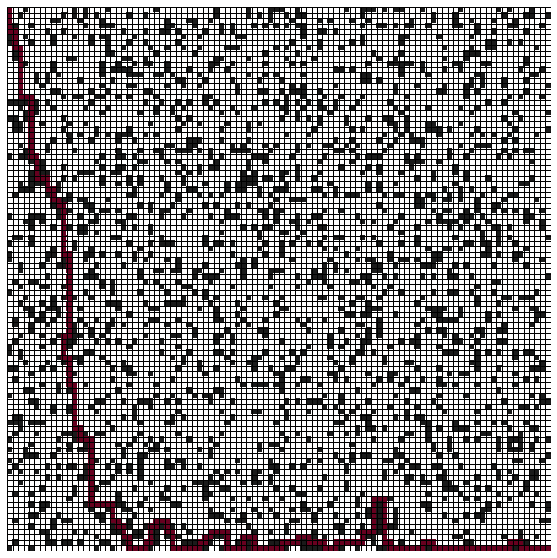

=== START ===


Shortest path length:  247
Nodes expanded:  488
Maximum fringe size:  209
The total execution time is: 0.016035900000019865


In [12]:
# Astar Original Maze 
obj5 = RelaxedMaze()
change = 0
obj5.run_astar(dim, p, heuristic,Original_maze_form,change)
      
execution_time = timeit.timeit()
print("The total execution time is:",execution_time)


The Dimensions of Original maze : 100
Lets check the relaxation heuristic with new dimension : 10
The Dimensions of Original maze : 100
Lets check the relaxation heuristic with new dimension : 10
Relaxed Maze is created!!
The Dimensions of Original maze : 100
Lets check the relaxation heuristic with new dimension : 10
new dim 10
Size of one Superblock : 10
superblock dimension : 0 0
10 10
The total weightage of a blocked cell: [0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 2, 0, 1, 0]
The mode of neighboring block nodes are: [0]
The new probability of new cells are(x,y,p) : 0 0 0.14
superblock dimension : 0 1
10 20
The total weightage of a blocked cell: [0, 0, 0, 0, 0, 1, 1, 1, 2, 1, 0, 2, 1, 1, 2, 0, 0, 0]
The mode of neighboring block nodes are: [0]
The new probability of new cells are(x,y,p) : 0 1 0.16
superblock dimension : 0 2
10 30
The total weightage of a blocked cell: [1, 1, 0, 0, 1, 1, 2, 1, 0, 1, 1, 1, 0, 0, 2, 2, 1, 2, 0, 0, 2, 3, 1, 3, 3, 0, 2, 1]
The mode of neighboring block nodes are: [

The total weightage of a blocked cell: [1, 3, 2, 2, 3, 0, 0, 2, 1, 1, 2, 1, 0, 1, 2, 1, 2, 1, 1, 1, 0, 0, 0, 1, 1]
The mode of neighboring block nodes are: [1]
The new probability of new cells are(x,y,p) : 3 6 0.20864864864864865
superblock dimension : 3 7
40 80
The total weightage of a blocked cell: [0, 2, 1, 2, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1]
The mode of neighboring block nodes are: [1]
The new probability of new cells are(x,y,p) : 3 7 0.20710526315789474
superblock dimension : 3 8
40 90
The total weightage of a blocked cell: [2, 1, 1, 1, 1, 0, 1, 0, 2, 1, 0, 0, 0, 0, 2, 0]
The mode of neighboring block nodes are: [0]
The new probability of new cells are(x,y,p) : 3 8 0.2058974358974359
superblock dimension : 3 9
40 100
The total weightage of a blocked cell: [0, 1, 3, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0]
The mode of neighboring block nodes are: [0]
The new probability of new cells are(x,y,p) : 3 9 0.20725
superblock dimension : 4 0
50 10
The total weig

The total weightage of a blocked cell: [1, 1, 2, 2, 2, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 2, 1, 2, 2]
The mode of neighboring block nodes are: [1]
The new probability of new cells are(x,y,p) : 7 1 0.20625
superblock dimension : 7 2
80 30
The total weightage of a blocked cell: [3, 2, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1]
The mode of neighboring block nodes are: [1]
The new probability of new cells are(x,y,p) : 7 2 0.2056164383561644
superblock dimension : 7 3
80 40
The total weightage of a blocked cell: [1, 2, 0, 1, 0, 0, 1, 0, 0, 1, 1, 2, 0, 2, 1, 1, 1, 1, 1]
The mode of neighboring block nodes are: [1]
The new probability of new cells are(x,y,p) : 7 3 0.20540540540540542
superblock dimension : 7 4
80 50
The total weightage of a blocked cell: [1, 0, 0, 0, 1, 1, 0, 1, 1, 2, 1, 1, 2, 1]
The mode of neighboring block nodes are: [1]
The new probability of new cells are(x,y,p) : 7 4 0.20453333333333334
superblock dimension : 7 5
80 60
The total weightage of a blocked cell: [1,

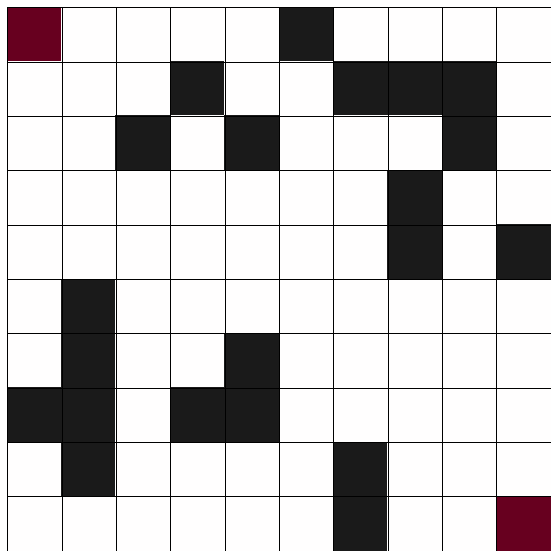

The combined version of original and relaxed maze is Ready!! 


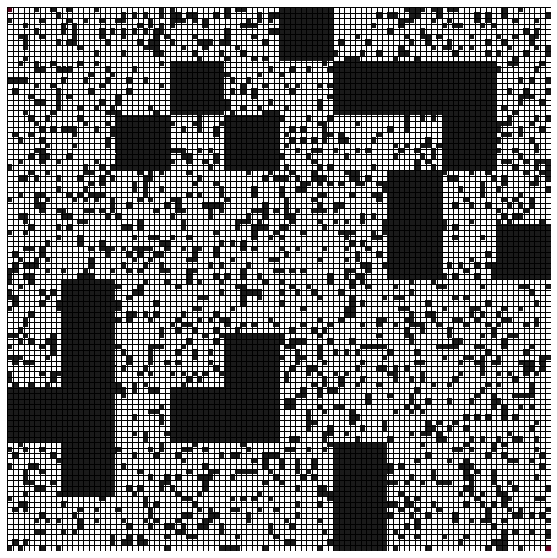

The total number of nodes search saved is: 2100
The Dimensions of Original maze : 100
Lets check the relaxation heuristic with new dimension : 10
length of self nodes 100

Path traversed:

=== GOAL ===
( 9 , 8 )
( 9 , 7 )
( 8 , 7 )
( 7 , 7 )
( 7 , 6 )
( 7 , 5 )
( 8 , 5 )
( 9 , 5 )
( 9 , 4 )
( 9 , 3 )
( 9 , 2 )
( 8 , 2 )
( 7 , 2 )
( 6 , 2 )
( 5 , 2 )
( 4 , 2 )
( 4 , 1 )
( 4 , 0 )
( 3 , 0 )
( 2 , 0 )
( 1 , 0 )


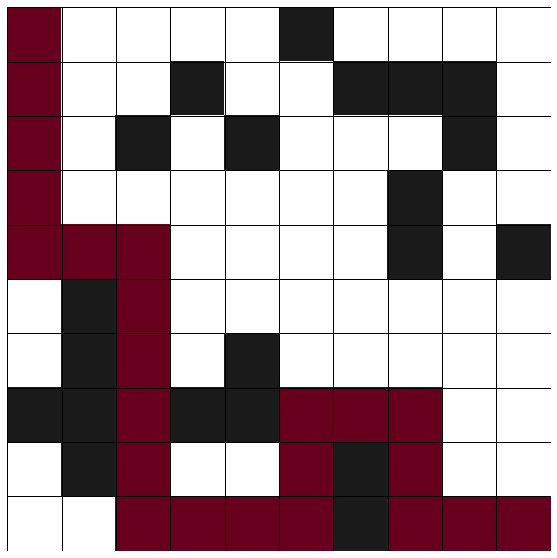

=== START ===


Shortest path length:  23
Nodes expanded:  41
Maximum fringe size:  16
The total execution time is: 0.018049499999960972


In [13]:
#Astar in relaxed Maze 
obj2=RelaxedMaze()
maze = obj1.select_relax_maze (dim,p)
change = 1                       #Astar in relax form of the maze          
Astar_relax_maze = obj2.run_astar(dim, p, heuristic,maze,change)
        
execution_time = timeit.timeit()
print("The total execution time is:",execution_time)

In [14]:
#If relaxed version of maze is solvable then try to use Astar in reduced version of original maze 
class New_Maze(object):
    
    def reduced_maze(self,dim,p,relax_maze,combined_maze):
        self.solved_relax_maze = relax_maze
        self.unsolved_ori_maze = combined_maze
        self.dim =dim
        new_dim = OriginalMaze.get_newdim (self,dim,p)
        ptr = int(self.dim/new_dim)
         #The nodes which are not part of the optimal path of relaxed maze will be blocked in original maze
        for row in range (new_dim):
            for column in range (new_dim):
                if self.solved_relax_maze[row][column] != 2: 
                    new_x = int(ptr*(row+1))
                    new_y = int(ptr *(column+1))
                    #print(new_x,new_y)
                    for x in range (new_x-ptr,new_x,1):
                        for y in range(new_y-ptr,new_y,1):
                            if self.unsolved_ori_maze[x][y] == 1:
                                self.unsolved_ori_maze[x][y] = 0   #if node is open make it block
        
        display.print_maze(self.unsolved_ori_maze)
        reduced_maze = self.unsolved_ori_maze 
        return reduced_maze
                                
                            
     
            
        
        
        

The Dimensions of Original maze : 100
Lets check the relaxation heuristic with new dimension : 10


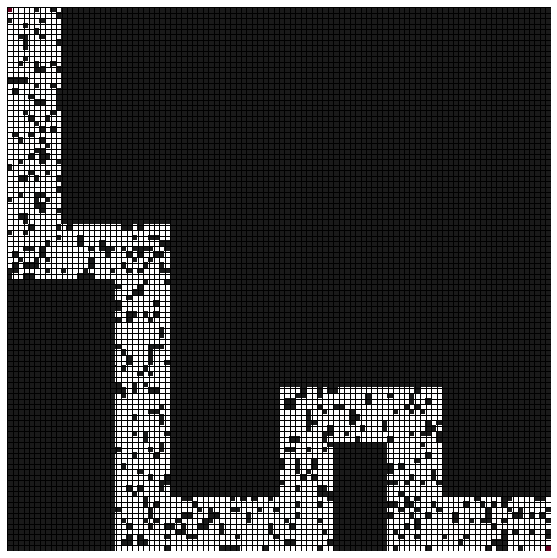

length of self nodes 10000

Path traversed:

=== GOAL ===
( 99 , 98 )
( 99 , 97 )
( 99 , 96 )
( 99 , 95 )
( 98 , 95 )
( 98 , 94 )
( 98 , 93 )
( 98 , 92 )
( 97 , 92 )
( 96 , 92 )
( 95 , 92 )
( 95 , 91 )
( 95 , 90 )
( 96 , 90 )
( 97 , 90 )
( 97 , 89 )
( 97 , 88 )
( 98 , 88 )
( 98 , 87 )
( 99 , 87 )
( 99 , 86 )
( 99 , 85 )
( 99 , 84 )
( 99 , 83 )
( 99 , 82 )
( 99 , 81 )
( 99 , 80 )
( 99 , 79 )
( 99 , 78 )
( 98 , 78 )
( 98 , 77 )
( 98 , 76 )
( 97 , 76 )
( 96 , 76 )
( 95 , 76 )
( 94 , 76 )
( 93 , 76 )
( 92 , 76 )
( 91 , 76 )
( 90 , 76 )
( 89 , 76 )
( 89 , 75 )
( 89 , 74 )
( 89 , 73 )
( 88 , 73 )
( 88 , 72 )
( 87 , 72 )
( 86 , 72 )
( 86 , 71 )
( 85 , 71 )
( 84 , 71 )
( 83 , 71 )
( 82 , 71 )
( 81 , 71 )
( 80 , 71 )
( 79 , 71 )
( 78 , 71 )
( 78 , 70 )
( 78 , 69 )
( 79 , 69 )
( 79 , 68 )
( 79 , 67 )
( 79 , 66 )
( 79 , 65 )
( 78 , 65 )
( 78 , 64 )
( 78 , 63 )
( 79 , 63 )
( 79 , 62 )
( 79 , 61 )
( 79 , 60 )
( 78 , 60 )
( 77 , 60 )
( 76 , 60 )
( 76 , 59 )
( 76 , 58 )
( 77 , 58 )
( 77 , 57 )
( 78 ,

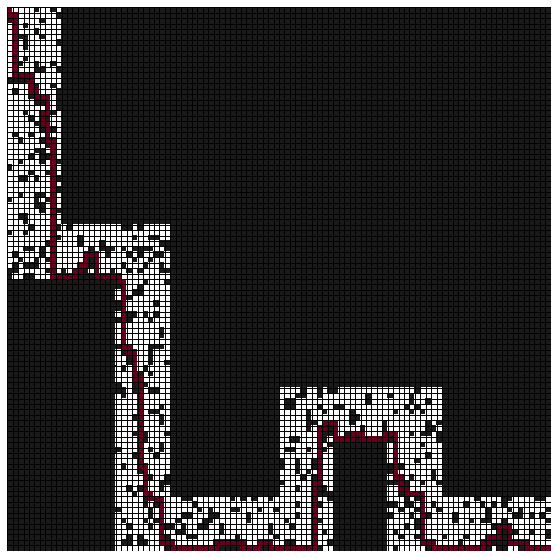

=== START ===


Shortest path length:  271
Nodes expanded:  722
Maximum fringe size:  237
The total execution time is: 0.018862600000034035


In [15]:
#Astar in reduced form of the original maze
obj4 = RelaxedMaze()
obj3 = New_Maze()
combined_maze = obj1.select_original_maze (dim,p)
reduced_ori_maze = obj3.reduced_maze(dim,p,Astar_relax_maze,combined_maze)
change = 0                     
obj4.run_astar(dim, p, heuristic,reduced_ori_maze,change)
      
execution_time = timeit.timeit()
print("The total execution time is:",execution_time)


# Relaxation Heuristic using Astar Algorithm:

Relaxation Strategy Name: Cubes inside a cube!!

#Motivation:
The relaxation strategy is useful to avoid the searching of multiple nodes in "higher dimensions" of the maze

#Results:
Case 1: dim = 100, p =0.1
Comparing number of nodes traversed:
1. Astar in original maze = 239   :)
2. Astar in relaxed maze = 217 (savings!!)   :)

Analysis: Startegy is viable with given threshold logic

Case 2: dim = 100, p =0.3
1. The Astar in original maze has optimal path (253 nodes)  :)
2. The Astar in relaxation maze (superblock version) has a optimal path  :)
3. Astar in the reduced version of original maze using information from relaxed version optimal path (refers 2.) the maze is unsolvable!  :(

Anaysis: The same threshold logic in case 1 gives the inference that as original maze has optimal path so does the relaxed version. But restricting search space only in the optimal path may not give us the required solution for solving the original maze. 

Possibilities for failure:
1. Threshold logic should be changed and see the performance (But how to decide optimal threshold satisfying all scenarios?)
2. Too much restrictions may not give us the optimal path with p >= 0.3

Case 3: dim = 100, p = 0.2
1. The Astar in original maze = 229 :)
2. The Atsar in relaxed maze = 269    :)
3. 40 extra nodes searching takes place than original form of maze   :(

Analysis: The relaxation startegy is correctly predicting the solvability of the maze but due to restricting the search space the total no of nodes traversed in optimal path is more than that of original path

Case 4: dim =100, p = 0.4
1. The original maze is unsolvable   :)
2. The relaxed version of maze is also unsolvable  :)

Analysis:  As the original form of the maze is unsolvable and so does its superblock version is reflecting that the maze is unsolvable. Thus the relaxation technique is predicting the original maze problem upto desired results.  

Case 5: dim =1000, p =0.1
1. The original maze is solvable = 2167 nodes   :)
2. The relaxed version is sometimes not solvable   :(

Analysis:For higher dimension the threshold value affects the results drastically. We should think about coming up with the good strategy to retain the original blockage properties of the maze(dynamic threshold value)

This shows that the relaxation technique is viable strategy as its minimizing our search space and giving optimal solution

#Scope of brainstorming:
1. Optimal technique to decide value of the threshold for superblock version of the maze
    Note: Two methods for calculating relaxation cost are used
          1)Blocked Neighbor Weight
          2)Blockage Probability as a weight
          
2. How to attempt the conditions where following the relaxed version optimal path gives o/p "maze is not solvable" but in its      original version its still solvable.(Again in my opinion this will get solved if we have a optimal way of the first scope of    brainstorming)

Note:I tried to show the Astar in relaxed version and combined version(relaxed + original) in order to compare its solvability and accuracy of performance!
